## Insight project 3.3
## validation for different models

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
sns.set()

In [9]:
#read data, apply 80:20 split for train vs validation
def shuffle(data, seed):    
    new_data = data.sample(frac=1, random_state=seed)
    train = new_data[:int(len(data) * 0.7)]
    val = new_data[int(len(data) * 0.7):]
    #print(train.shape)
    #print(val.shape)
    #print(train.head())
    #print(val.head())
    return train, val

In [10]:
#machine learning model svm
def svm_model(train, val):
    svm = SVC(C=6, probability=True, random_state=6, class_weight={1:3, 0:1})
    svm.fit(train.iloc[:, 2:].values, train.iloc[:, 1].values)
    pred = svm.predict_proba(val.iloc[:, 2:].values)
    svm_auc_score = roc_auc_score(val.iloc[:, 1].values, pred[:, 1])
    svm_fpr, svm_tpr, svm_thresholds = roc_curve(val.iloc[:, 1].values, pred[:, 1])
    #print('auc_score: {}'.format(svm_auc_score))
    return svm_auc_score, svm_fpr, svm_tpr, svm_thresholds


In [11]:
#random forest
def rf_model(train, val):
    rf = RandomForestClassifier(n_estimators=60, criterion='gini', max_features='sqrt', max_depth=None, 
                                min_samples_split=2, min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, 
                                oob_score=False, n_jobs=-1, random_state=6, verbose=0, warm_start=False,
                                class_weight={1:3, 0:1})
    rf.fit(train.iloc[:, 2:].values, train.iloc[:, 1].values)
    pred = rf.predict_proba(val.iloc[:, 2:].values)
    rf_auc_score = roc_auc_score(val.iloc[:, 1].values, pred[:, 1])
    rf_fpr, rf_tpr, rf_thresholds = roc_curve(val.iloc[:, 1].values, pred[:, 1])
    #print('auc_score: {}'.format(rf_auc_score))
    return rf_auc_score, rf_fpr, rf_tpr, rf_thresholds


In [12]:
#logistic regression
def lr_selection(train, val):
    lr = LogisticRegression(penalty='l1', C=10, tol=0.01, class_weight={1:3, 0:1})
    lr.fit(train.iloc[:, 2:].values, train.iloc[:, 1].values)
    index = np.where(lr.coef_ != 0)[1]
    index = index.astype(np.str)
    new_train = train[index]
    new_train.insert(loc=0, column='hits', value=train['hits'])
    new_train.insert(loc=0, column='names', value=train.iloc[:, 0])
    new_val = val[index]
    new_val.insert(loc=0, column='hits', value=val['hits'])
    new_val.insert(loc=0, column='names', value=val.iloc[:, 0])
    return new_train, new_val
    
    
def lr_model(train, val):
    lr = LogisticRegression(penalty='l1', C=10, tol=0.01, class_weight={1:3, 0:1})
    lr.fit(train.iloc[:, 2:].values, train.iloc[:, 1].values)
    pred = lr.predict_proba(val.iloc[:, 2:].values)
    lr_auc_score = roc_auc_score(val.iloc[:, 1].values, pred[:, 1])
    lr_fpr, lr_tpr, lr_thresholds = roc_curve(val.iloc[:, 1].values, pred[:, 1])
    #print('auc_score: {}'.format(lr_auc_score))
    return lr_auc_score, lr_fpr, lr_tpr, lr_thresholds


In [13]:
data = pd.read_csv('data/train.csv', index_col=False)
train, val = shuffle(data, 0) 
print(train.shape, val.shape)
print(val.head())
train, val = lr_selection(train, val)
print(train.shape, val.shape)
print(val.head())

(495, 4098) (213, 4098)
                      Unnamed: 0  hits    0    1    2    3    4    5    6  \
624                   Metyrapone     0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
372                   Topiramate     0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
168                Thyroxine (L)     1  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
347  Oxymetazoline hydrochloride     0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
376                Triamcinolone     0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       7  ...   4086  4087  4088  4089  4090  4091  4092  4093  4094  4095  
624  0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
372  0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
168  0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
347  0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
376  0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 4098 columns]
(495, 368) (213, 368)
    

In [26]:
#validation 
data = pd.read_csv('data/train.csv', index_col=False)
auc_scores = pd.DataFrame(columns=("feature selection", "LR", "RF", "SVM"))
i = 0
while(i < 100):
    train, val = shuffle(data, i)    
    auc_scores.loc[i] = ['no', lr_model(train, val)[0], rf_model(train, val)[0], svm_model(train, val)[0]]
    train, val = lr_selection(train, val)
    i += 1
    auc_scores.loc[i] = ['yes', lr_model(train, val)[0], rf_model(train, val)[0], svm_model(train, val)[0]]
    i += 1

auc_scores

,feature selection,LR,RF,SVM
0,no,0.597778,0.652963,0.603598
1,yes,0.593228,0.692116,0.629841
2,no,0.656863,0.763072,0.689058
3,yes,0.624546,0.736989,0.688574
4,no,0.705130,0.693130,0.697623
5,yes,0.691936,0.682325,0.683064
6,no,0.738973,0.754371,0.710866
7,yes,0.753362,0.749395,0.728349
8,no,0.727669,0.747942,0.689300
9,yes,0.701283,0.741467,0.692205


In [15]:
auc_scores.head()

,feature selection,LR,RF,SVM
0,no,0.593651,0.652963,0.603598
1,yes,0.596190,0.674286,0.619894
2,no,0.650448,0.763072,0.689058
3,yes,0.634350,0.741951,0.707153
4,no,0.709452,0.693130,0.697623


In [27]:
from scipy.stats import ttest_ind

a = ttest_ind(auc_scores['LR'], auc_scores['RF'])
b = ttest_ind(auc_scores['LR'], auc_scores['SVM'])
c = ttest_ind(auc_scores['SVM'], auc_scores['RF'])
(a, b, c)

(Ttest_indResult(statistic=-11.434961737895527, pvalue=1.409566095553887e-23),
 Ttest_indResult(statistic=-3.8060272731761362, pvalue=0.00018819770906394374),
 Ttest_indResult(statistic=-7.9835307061749354, pvalue=1.1338039128523653e-13))

In [ ]:
# x = np.arange(30)

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(x, auc_scores['lr'], c='g', linewidth=2.0, label="LR")
# ax.plot(x, auc_scores['rf'], c='b', linewidth=2.0, label="RF")
# ax.plot(x, auc_scores['svm'], c='k', linewidth=2.0, label="SVM")
# ax.set_xlabel("experiment", fontsize=20)
# ax.set_ylabel("auc_score", fontsize=20)
# ax.legend(loc="upper center", frameon=False, fontsize=18)
# sns.set_style('ticks')
# sns.despine(ax=ax)


# sns.set(style="ticks")
# sns.despine()
# plt.subplots_adjust(left=0.1, bottom=0.1, right=1.2, top=1.5, wspace=0.2, hspace=0.2)
# plt.xlabel("experiment", fontsize=20)
# plt.ylabel("auc_score", fontsize=20)
# plt.ylim((0.5, 0.95))

# plt.legend(loc="upper left", frameon=False, fontsize=24)



In [52]:
df = pd.melt(auc_scores, id_vars = ["feature selection"], value_vars = ["LR", "RF", "SVM"])
df.head()
df.to_csv("auc_scores.csv", index=False)

In [53]:
df = pd.read_csv("auc_scores.csv")
df.head()

,feature selection,variable,value
0,no,LR,0.597778
1,yes,LR,0.593228
2,no,LR,0.656863
3,yes,LR,0.624546
4,no,LR,0.705130


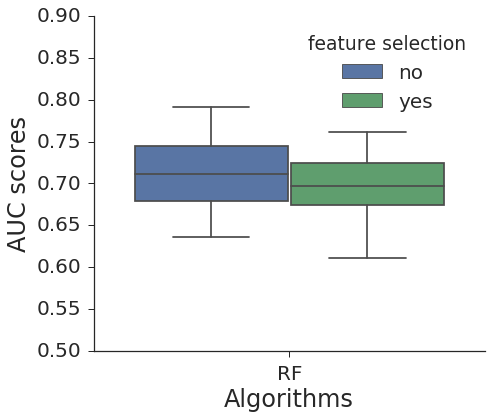

In [41]:
sns.set(rc={"figure.figsize": (7, 6)})
sns.set_style("ticks")
sns.set_context("notebook", font_scale=2)

#sns.set_palette("bright")

#ax = sns.boxplot(x="variable", y="value", data=df[df['feature selection'] == 'no'])
ax = sns.boxplot(x="variable", y="value", data=df[df['variable'] == 'RF'], hue="feature selection")
#ax = sns.stripplot(x="variable", y="value", data=df, jitter=0.15, hue="feature selection", split=True)
ax.set_ylim(0.5, 0.9)
ax.set_xlabel("Algorithms", size=24)
ax.set_ylabel("AUC scores", size=24)
sns.despine()


In [47]:
from scipy.stats import ttest_ind

a = ttest_ind(df[(df['variable'] == 'RF') & (df['feature selection'] == 'yes')]['value'], df[(df['variable'] == 'RF') & (df['feature selection'] == 'no')]['value'])
a

Ttest_indResult(statistic=-2.0725365727321106, pvalue=0.040840546927476067)

In [22]:
data = pd.read_csv('data/train.csv', index_col=False)
train, val = shuffle(data, 6)
lr_auc, lr_fpr, lr_tpr, lr_thres = lr_model(train, val)
rf_auc, rf_fpr, rf_tpr, rf_thres = rf_model(train, val)
svm_auc, svm_fpr, svm_tpr, svm_thres = svm_model(train, val)
print(lr_auc, rf_auc, svm_auc)        
#auc_scores



0.741527703066 0.754370629371 0.71086605702


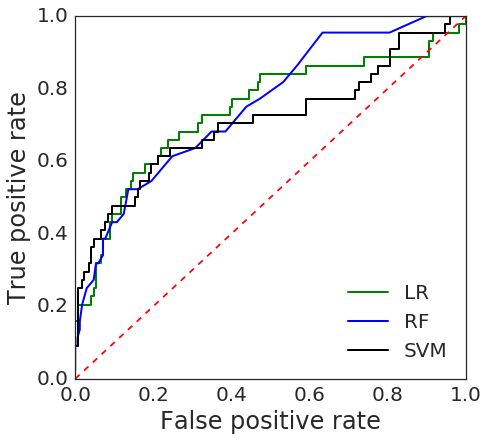

In [25]:
#plot all roc
# plt.subplots_adjust(left=0.1, bottom=0.1, right=1.2, top=1.5, wspace=0.2, hspace=0.2)
# plt.xlabel("false positive rate", fontsize=20)
# plt.ylabel("true positive rate", fontsize=20)
# plt.xlim(-0.02, 1.02)
# plt.ylim(-0.02, 1.02)
# plt.plot(lr_fpr, lr_tpr, c='g', linewidth=2.0, label="Logistic Regression")
# plt.plot(rf_fpr, rf_tpr, c='b', linewidth=2.0, label="Random Forest")
# plt.plot(svm_fpr, svm_tpr, c='k', linewidth=2.0, label="Support Vector Machine")
# plt.plot([0, 1], [0, 1], c='r', linewidth=1.0)
# plt.legend(loc="upper left", frameon=False)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(7, 6.5))
ax.plot(lr_fpr, lr_tpr, c='g', linewidth=2.0, label="LR")
ax.plot(rf_fpr, rf_tpr, c='b', linewidth=2.0, label="RF")
ax.plot(svm_fpr, svm_tpr, c='k', linewidth=2.0, label="SVM")
ax.plot([0, 1], [0, 1], 'r--')
ax.set_xlabel("False positive rate", fontsize=24)
ax.set_ylabel("True positive rate", fontsize=24)
ax.legend(loc="lower right")
